# Deep Convolutional GAN (DCGAN) to generate Arabic Hand-Written Digits

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Imports Libraries

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.utils import save_image, make_grid
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

nc = 1  # Number of channels in the training images.

img_size = 64
image_shape = torch.tensor([nc, img_size, img_size])

batch_size = 64

nz = 100  #Size of z latent vector (

ngf = 64    # Size of feature maps in generator

ndf = 64    # Size of feature maps in discriminator

lr = 0.0002

n_epochs = 10

sample_interval = 100  # to save fake images
batch_interval = 450   # to report result

beta1 = 0.5   # Beta1 hyperparam for Adam optimizers

os.makedirs('images', exist_ok=True)

In [4]:
# rm -r ./images

# Import data from kaggle

In [5]:
!pip install kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d mloey1/ahdd1

 63% 32.0M/50.6M [00:00<00:00, 68.8MB/s]
100% 50.6M/50.6M [00:00<00:00, 93.7MB/s]


In [8]:
!unzip ahdd1.zip

Archive:  ahdd1.zip
  inflating: Arabic Handwritten Digits Dataset CSV/csvTestImages 10k x 784.csv  
  inflating: Arabic Handwritten Digits Dataset CSV/csvTestLabel 10k x 1.csv  
  inflating: Arabic Handwritten Digits Dataset CSV/csvTrainImages 60k x 784.csv  
  inflating: Arabic Handwritten Digits Dataset CSV/csvTrainLabel 60k x 1.csv  
  inflating: Train + Test Matlab.mat  
  inflating: csvTestImages 10k x 784.csv  
  inflating: csvTestLabel 10k x 1.csv  
  inflating: csvTrainImages 60k x 784.csv  
  inflating: csvTrainImages 60k x 784/csvTrainImages 60k x 784.csv  
  inflating: csvTrainLabel 60k x 1.csv  


In [10]:
train_image = pd.read_csv("/content/csvTrainImages 60k x 784.csv", header = None)
len(train_image),train_image.isnull().sum().sum()


(60000, 0)

# Prepare Dataset and DataLoader

In [11]:
class ImageDataset(Dataset):
    
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
      
        image = self.data.iloc[index, self.data.columns != 'label'].values.astype(np.uint8).reshape(28, 28)
        label = self.data.iloc[index, -1] - 1
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [12]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

dataset = ImageDataset(train_image, transform)

In [13]:
dataloader = DataLoader(dataset, 
                        batch_size=batch_size,
                        shuffle=True)

In [14]:
print(len(dataset), len(dataloader))

60000 938


In [45]:
batch = next(iter(dataloader))
batch[0].dtype,batch[0].shape

(torch.float32, torch.Size([64, 1, 64, 64]))

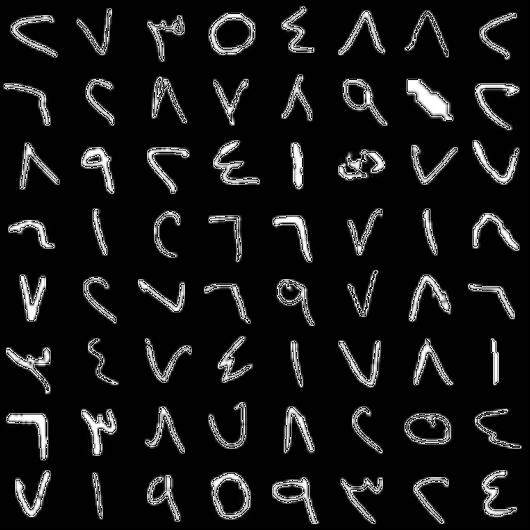

In [46]:
from PIL import Image
image = transforms.ToPILImage()(make_grid(batch[0]))
image  = image.rotate(-90)
image  = image.transpose(Image.FLIP_LEFT_RIGHT)
display(image)

# Building DCGAN Model

## Generator

In [47]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.model(input)

In [48]:
generator = Generator()

In [49]:
generator(torch.randn(batch_size, nz, 1, 1)).shape

torch.Size([64, 1, 64, 64])

## Discriminator

In [50]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [51]:
discriminator = Discriminator()

In [52]:
discriminator(torch.rand(batch_size, *image_shape)).shape

torch.Size([64, 1, 1, 1])

# Train DCGAN

## Config: Optimizers and losses

In [53]:
criterion = nn.BCELoss()

optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

## Training Loop

In [57]:
iters = 0
real_label = 1.
fake_label = 0.

print("Starting Training Loop ...")
for epoch in range(n_epochs):
    for i, (data,_) in enumerate(dataloader, 0):

        #---------------------------
        # (1) Update Discriminator : maximize log(D(x)) + log(1 - D(G(z)))
        #---------------------------
        
        # (1-1) Train with all-real batch
        discriminator.zero_grad()
        real_data = data.to(device)
        real_labels = torch.full((data.size(0),), real_label, dtype=torch.float, device=device)
        output = discriminator(real_data).view(-1)
        loss_D_real = criterion(output, real_labels)
        loss_D_real.backward()

        #(1-2) Train with all-fake batch
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_image = generator(noise)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        output = discriminator(fake_image.detach()).view(-1)
        loss_D_fake = criterion(output, fake_labels)
        loss_D_fake.backward()
        loss_D = loss_D_real + loss_D_fake
        optimizer_D.step()

        #---------------------------
        # (2) Update Generator network: maximize log(D(G(z)))
        #---------------------------
        generator.zero_grad()
        fake_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(fake_image).view(-1)
        loss_G = criterion(output, fake_labels)
        loss_G.backward()
        optimizer_G.step()

        # Output training stats
        if i % batch_interval == 0:
          print(f'Epoch: {epoch}/{n_epochs}, Batch: {i}/{len(dataloader)}, Loss D: {loss_D.item()}, Loss G: {loss_G.item()}, ')

          if (iters % sample_interval == 0) or (epoch == n_epochs-1):
            save_image(fake_image, f'images/{iters}.png', normalize=True)

        iters += 1

# Plot generated numbers

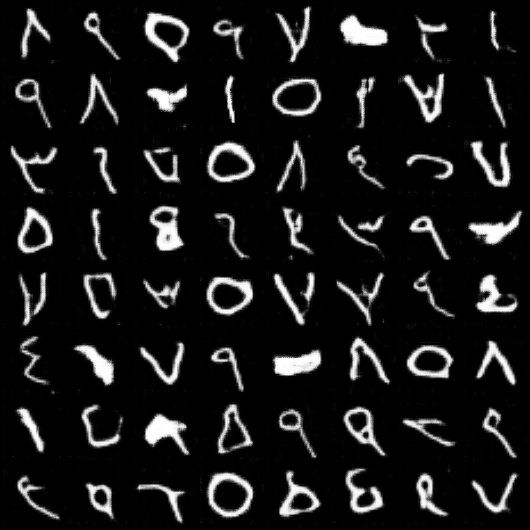

In [43]:
from PIL import Image
image  = Image.open("/content/images/9370.png")
image  = image.rotate(-90)
image  = image.transpose(Image.FLIP_LEFT_RIGHT)
display(image)